# Последняя домашка в семестре
Тут нужно показать что я смогу сделать несколько базовых вещей и чтобы `NN` заработала

Вот лучший результат, который показали случайные деревья

Test

	precision=0.80
	recall   =0.77
	f1       =0.79
Train

	precision=0.99
	recall   =0.96
	f1       =0.97

In [35]:
paht_to_data = '../04_Forests/HW/data'

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [37]:
train_data = pd.read_csv(f'{paht_to_data}/train.csv')

Тут мы просто слелаем `one hot encoding`, удалим пару неинформативных столбцов, подробей в `../04_Forests/HW`

In [38]:
def preprocess(df: pd.DataFrame()) -> pd.DataFrame():
    out = df.copy()
    out.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)
    
    cleanup_sex = {"Sex": {"male": 1, "female": 0}}
    out.replace(cleanup_sex, inplace=True)
    
    out = pd.get_dummies(out, columns=["Embarked"])
    
    out['Age'].fillna((out['Age'].mean()), inplace=True)
    return out

In [39]:
train_data_1 = preprocess(train_data)

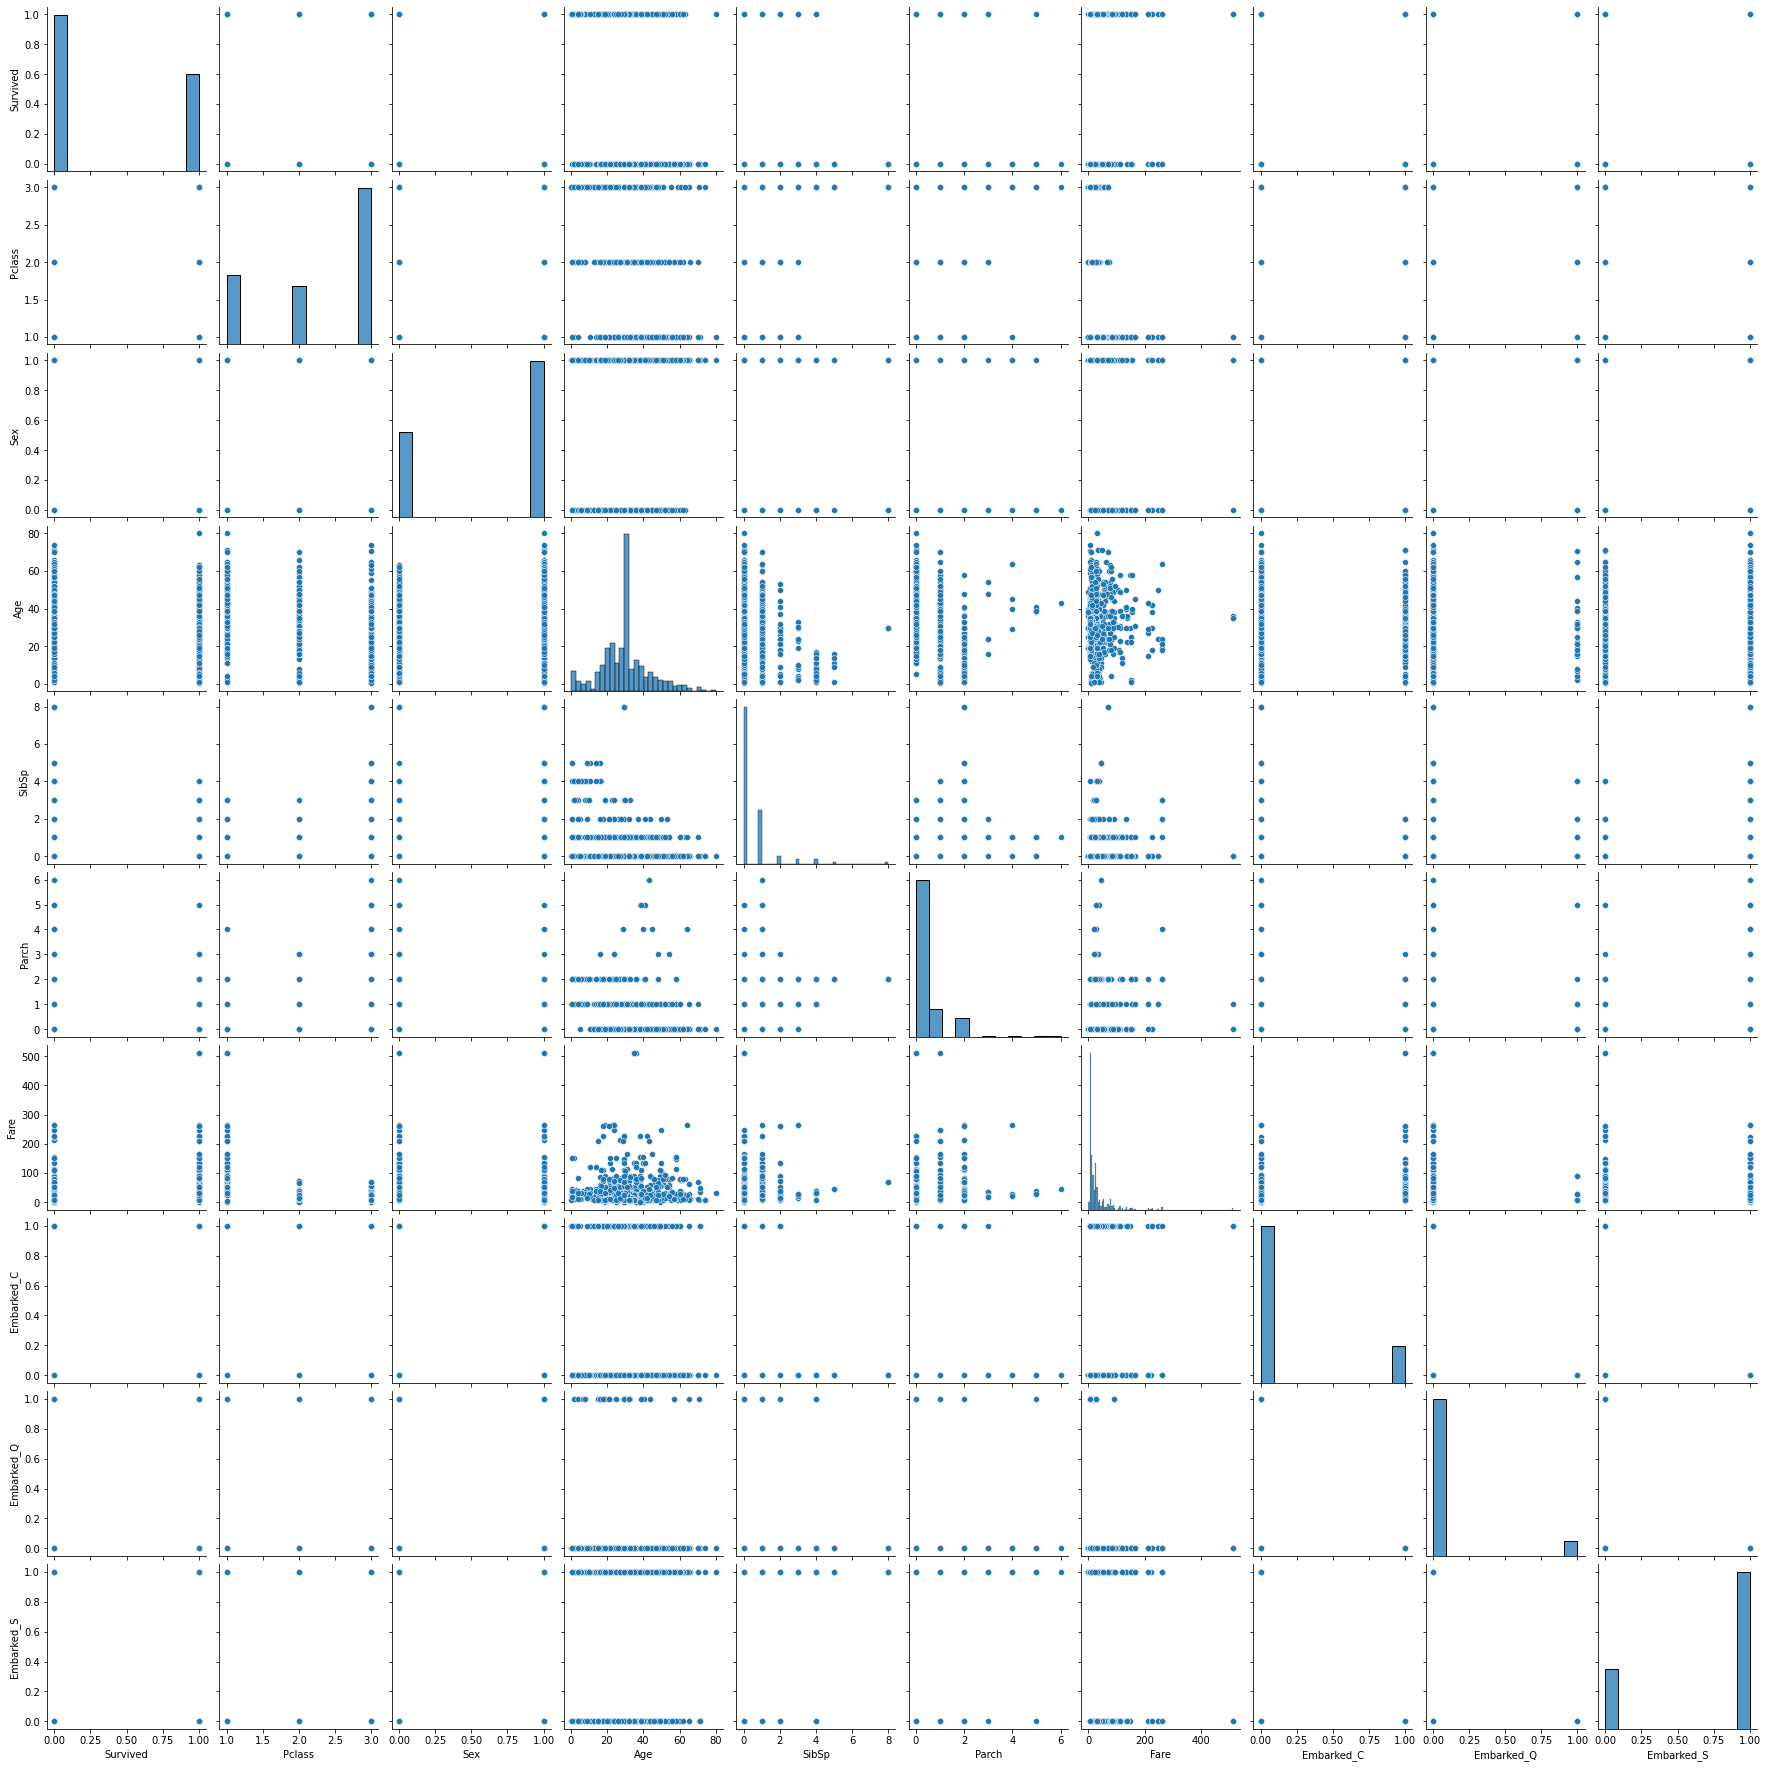

In [40]:
sns.pairplot(train_data_1)
plt.show()

Просто сделаем нейронку как в прошлом ноутбуке)

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from keras.models import Model

In [42]:
train_data_1.shape

(891, 10)

In [43]:
import keras.backend as K

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [44]:
def model_by_functional_api_drop_bathc(hp, inp_dim=9, output_dim=2, optimizer='adam', dropout=0.1, batch_norm=True):
    
    hidden_dim_1 = hp.Int('hidden_1', min_value=2, max_value=16, step=3)
    hidden_dim_2 = hp.Int('hidden_2', min_value=2, max_value=16, step=3)
    dropout = hp.Choice('dropout', values=list(np.linspace(0.01, 0.2, 7)))
    batch_n = hp.Choice('bathc_norm', values=[True, False])
    
    input1 = Input(shape=(inp_dim,))
    hidden1 = Dense(hidden_dim_1,
                    activation='relu')(input1)
    hidden1 = tf.keras.layers.Dropout(dropout, input_shape=(hidden_dim_1,))(hidden1)
    if batch_n:
        hidden1 = tf.keras.layers.BatchNormalization()(hidden1)
    hidden2 = Dense(hidden_dim_2, activation='relu')(hidden1)
    hidden2 = tf.keras.layers.Dropout(dropout, input_shape=(hidden_dim_2,))(hidden2)
    if batch_n:
        hidden2 = tf.keras.layers.BatchNormalization()(hidden2)
    output = Dense(output_dim, activation='softmax')(hidden2)
    model = Model(inputs=input1, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Кроме модели нужно рскидать данные в 4 кучки

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
def load_dataset(df, flatten=False):
    x = train_data_1.drop(columns=['Survived'])
    y = train_data_1['Survived']
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    
    # Оставим 10000 примеров на валидацию
    val_size = int(0.2 * X_train.shape[0])
    X_train, X_val = X_train[:-val_size], X_train[-val_size:]
    y_train, y_val = y_train[:-val_size], y_train[-val_size:]
    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(train_data_1)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_val = sc.transform(X_val)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [47]:
import kerastuner

In [48]:
tuner = kerastuner.tuners.BayesianOptimization(
    model_by_functional_api_drop_bathc,
    objective='val_accuracy',
    executions_per_trial=5,
    directory='my_dir',
    max_trials=300
)

In [49]:
tuner.search(X_train, y_train, validation_data=(X_val, y_val))

Trial 1 Complete [00h 00m 03s]
val_accuracy: 0.4943662047386169

Best val_accuracy So Far: 0.4943662047386169
Total elapsed time: 00h 00m 03s

Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
hidden_1          |14                |8                 
hidden_2          |8                 |5                 
dropout           |0.2               |0.13667           
bathc_norm        |0                 |0                 

 1/18 [>.............................] - ETA: 0s - loss: 0.7341 - accuracy: 0.3125

KeyboardInterrupt: 

Ну вот, нейронка запустилась. Результаты так себе. Впринципе показал что чтото работает

Мб если ещё запустить, то нормал отработает

In [ ]:
tuner.results_summary()

In [ ]:
b_model = tuner.get_best_models()[0]

Это всё конечно хорошо, но как быть то что `accuracy` такое маленькое? Мб ещё пообучать?

In [ ]:
# '''
import datetime
log_dir = "logs_adagrad/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = b_model.fit(X_train, y_train, epochs=120, batch_size=30, 
              validation_data=(X_test, y_test), callbacks=[tensorboard_callback], verbose=1)
#'''

Нестабильно, плохо, лес с этой задачей српавился лучше

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
clf = LogisticRegression(random_state=134).fit(X_train, y_train)
y_test_hat = clf.predict(X_test)
pr, rec, f1, _ = precision_recall_fscore_support(y_test, y_test_hat, average='binary')
print(f'Test\n\tprecision={pr:.2f}\n\trecall   ={rec:.2f}\n\tf1       ={f1:.2f}')
print(f'\taccuracy={accuracy_score(y_test, y_test_hat)}')

Да и логистическая регрессия